# Data Cleaning

**Main Objective:**  
In this notebook we inspect and clean missing or duplicate values in the three main datasets:

1. **Raw CVs** (original, unstructured CV text)  
2. **Parsed Skills** (the `cv_skills` DataFrame that feeds the matcher)  
3. **Matcher Results** (output CSV from the matching algorithm)

In [248]:
%load_ext autoreload 
%autoreload 2

import polars as pl

from hiring_cv_bias.cleaning.common import (
    cramers_v,
    filter_out_candidate_ids,
    find_garbage_skill_rows,
    inspect_missing,
    plot_cramer_matrix,
)
from hiring_cv_bias.cleaning.raw_cv import (
    add_length_column,
    assess_translation_completeness,
    detect_corrupted_cvs,
    detect_repetitive_cvs,
    detect_vocab_sparsity,
    filter_placeholder_tails,
    find_and_print_short_cvs,
    is_this_language,
    plot_length_histogram,
)
from hiring_cv_bias.config import (
    CANDIDATE_CVS_TRANSLATED_PATH,
    PARSED_DATA_PATH,
    REVERSE_MATCHING_PATH,
)
from hiring_cv_bias.utils import (
    filter_unknown_and_other_rows,
    load_data,
    load_excel_sheets,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. **Raw CVs** Cleaning Steps

### 1. Schema & Load 


   - Define expected columns and data types
   - Load CSV into Polars DataFrame, verify row count matches the number of uniques Candidate IDs.

In [249]:
raw_cv = load_data(CANDIDATE_CVS_TRANSLATED_PATH)
print("DataFrame schema:", raw_cv.schema)
print(f"Loaded: {raw_cv.height} CVs")

################

total_rows = raw_cv.height
unique_ids = raw_cv.select(pl.col("CANDIDATE_ID")).unique().height
print(f"Unique CANDIDATE_ID: {unique_ids}")
display(raw_cv.sample(5))

DataFrame schema: Schema({'CANDIDATE_ID': Int64, 'CV_text_anon': String, 'Translated_CV': String})
Loaded: 7769 CVs
Unique CANDIDATE_ID: 7769


CANDIDATE_ID,CV_text_anon,Translated_CV
i64,str,str
6892877,"""CV anonimizzato: """""" Traduttri…",""" translator en&lt;&gt;it, es&l…"
5216553,"""CV anonimizzato: """""" Formato …",""" European format for CV person…"
6965925,"""CV anonimizzato: """""" ㅡ Possied…",""" ㅡ I have a certificate of low…"
7329099,"""CV anonimizzato: """""" F O…",""" europeanformatforcurriculumvi…"
1698394,"""CV anonimizzato: """""" Operaia I…",""" worker contact information da…"


### 2. Missing Value Inspection 


   - Count nulls per column, compute percentage of missing values and report any columns with > 0% missing.

In [250]:
inspect_missing(raw_cv)

Missing value summary:



column,n_missing,pct_missing
str,u32,f64
"""CANDIDATE_ID""",0,0.0
"""CV_text_anon""",0,0.0
"""Translated_CV""",0,0.0



No missing values detected in any column.


### 3. Short or Empty CV Detection  

Under this step we will:

1. **Empty / Whitespace-Only/ Very Short Text** 

   - Filter out any records where `CV_text_anon` is below a chosen threshold (e.g. 300 characters), showing their IDs and snippets for manual review.

2. **High Repetition**
   - Split each CV into non-empty lines, count `n_lines` and `unique_lines`.  
   - Compute `repetition_ratio = 1 − (unique_lines / n_lines)`.  
   - Flag and drop any CVs with `repetition_ratio` above a threshold (e.g. > 0.7).
   - These checks ensure we remove any CVs that are dominated by boilerplate before proceeding with further analysis.

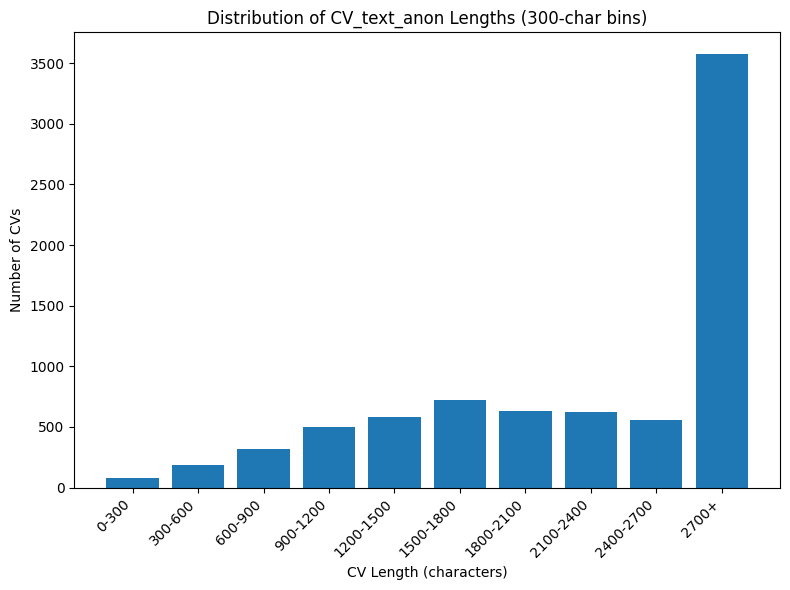

In [251]:
plot_length_histogram(raw_cv, text_col="CV_text_anon", bin_size=300, max_bin=3000)

Remove Empty / Whitespace-Only/ Very Short Text

In [252]:
raw_cv = add_length_column(raw_cv, text_col="CV_text_anon", length_col="len_anon")


too_short_df = find_and_print_short_cvs(
    raw_cv,
    length_col="len_anon",
    threshold=300,
    id_col="CANDIDATE_ID",
    text_col="CV_text_anon",
)

Found 77 CVs with CV_text_anon < 300 chars. Showing up to 10:
 1. ID 7560889: 263 chars
 2. ID 7456101: 29 chars
 3. ID 7437776: 279 chars
 4. ID 7414638: 110 chars
 5. ID 7373536: 58 chars
 6. ID 7364629: 202 chars
 7. ID 7347338: 82 chars
 8. ID 7330315: 237 chars
 9. ID 7230306: 238 chars
 10. ID 7163148: 253 chars

Example full CV for ID 5475487:
'CV anonimizzato:\n"""\n03/2006 - 01/2010\n02/1995 - 01/2006\n04/1987 - 01/1995\n10/1981 - 01/1987Autorizzo il trattamento dei miei dati personali presenti nel curriculum vitae ai sensi del Decreto Legislativo 30 giugno 2003, n. 196 e del GDPR (Regolamento UE 2016/679).\n"""'


In [253]:
short_cvs_ids = too_short_df.select(pl.col("CANDIDATE_ID")).to_series().to_list()
raw_cv_cleaned = filter_out_candidate_ids(
    raw_cv, short_cvs_ids, df_name="CVs", description="under 300 characters"
)

CVs with under 300 characters: 77 out of 7769 total
That is 0.99% of all cvs
CVs -> Original rows: 7769
CVs -> Dropped rows:  77 (IDs in provided list)
CVs -> Remaining rows: 7692


Remove High Repetition / Low Structure CVs  

In [254]:
repetitive_cvs = detect_repetitive_cvs(
    raw_cv_cleaned, text_col="CV_text_anon", max_repetition=0.5
)
print(f"Found {repetitive_cvs.height} repetitive CVs:")
display(repetitive_cvs.select(["CANDIDATE_ID", "n_lines", "repetition_ratio"]))

Found 39 repetitive CVs:


CANDIDATE_ID,n_lines,repetition_ratio
i64,i64,f64
7259455,244,0.553279
7026944,105,0.971429
6981854,134,0.835821
6876738,195,0.548718
6788013,103,0.514563
…,…,…
164616,401,0.992519
153773,58,0.706897
125099,172,0.523256


In [255]:
repetitive_cvs_ids = repetitive_cvs.select(pl.col("CANDIDATE_ID")).to_series().to_list()
raw_cv_cleaned = filter_out_candidate_ids(
    raw_cv_cleaned, repetitive_cvs_ids, df_name="CVs", description="repetitive CVs"
)

CVs with repetitive CVs: 39 out of 7692 total
That is 0.51% of all cvs
CVs -> Original rows: 7692
CVs -> Dropped rows:  39 (IDs in provided list)
CVs -> Remaining rows: 7653


### 4. Text Quality Checks

Furthermore we filter out “bad” or malformed CVs, for doing that we will perform:

1. **Token & Vocabulary Richness**  
   - Calculate the unique words / total words ratio to measure lexical variety.
   - Filter out CVs with very low number of unique words (e.g < 20) or very low ratio (e.g. < 0.2).

2. **Detect Placeholder Tails**
   - Flag any CV whose text ends with a long run of the same character (e.g. “XXXXXXXXXX…”), seen after manual inspection. These indicate no usable content and should be excluded.

3. **Detect Corrupted CVs**
   - Compute the fraction of “unusual” characters in each CV. Flag and remove any CV where this fraction exceeds a small threshold (e.g. 3%), catching heavily distorted documents.


These additional checks will help us catch CVs that are too short, overly repetitive, or structurally invalid.

**Token & Vocabulary Richness**  

In [256]:
sparse_cvs = detect_vocab_sparsity(
    raw_cv_cleaned, text_col="CV_text_anon", min_words=30, min_ttr=0.3
)

print(f"CVs to discard based on vocabulary sparsity: {sparse_cvs.height}")
display(
    sparse_cvs.select(["CANDIDATE_ID", "total_words", "unique_words", "ttr"]).sort(
        pl.col("ttr"), descending=False
    )
)

CVs to discard based on vocabulary sparsity: 48


CANDIDATE_ID,total_words,unique_words,ttr
i64,i64,i64,f64
6206994,1291,242,0.187452
7080072,755,149,0.197351
6015186,931,191,0.205156
6809297,462,101,0.218615
6987708,1621,375,0.231339
…,…,…,…
6501990,17,16,0.941176
4479547,17,16,0.941176
3583383,22,21,0.954545


In [257]:
sparse_ids = sparse_cvs.select(pl.col("CANDIDATE_ID")).to_series().to_list()
raw_cv_cleaned = filter_out_candidate_ids(
    raw_cv_cleaned, sparse_ids, df_name="CVs", description="low lexical variety"
)

CVs with low lexical variety: 48 out of 7653 total
That is 0.63% of all cvs
CVs -> Original rows: 7653
CVs -> Dropped rows:  48 (IDs in provided list)
CVs -> Remaining rows: 7605


**Detect Placeholder Tails**

In [258]:
placeholder_cvs = filter_placeholder_tails(
    raw_cv_cleaned, text_col="CV_text_anon", char="X", min_run=20
)
print(f"Found {placeholder_cvs.height} CVs with trailing X placeholders:")
display(placeholder_cvs.select(["CANDIDATE_ID"]))

Found 52 CVs with trailing X placeholders:


CANDIDATE_ID
i64
7471471
7423990
7386710
7295445
7228164
…
166297
156390
151354


In [259]:
placeholder_ids = placeholder_cvs.select(pl.col("CANDIDATE_ID")).to_series().to_list()
raw_cv_cleaned = filter_out_candidate_ids(
    raw_cv_cleaned,
    placeholder_ids,
    df_name="CVs",
    description="trailing X placeholders",
)

CVs with trailing X placeholders: 52 out of 7605 total
That is 0.68% of all cvs
CVs -> Original rows: 7605
CVs -> Dropped rows:  52 (IDs in provided list)
CVs -> Remaining rows: 7553


**Detect Corrupted CVs**

In [260]:
corrupted_cvs = detect_corrupted_cvs(
    raw_cv_cleaned, text_col="CV_text_anon", max_unusual_frac=0.02
)
print(f"Corrupted CVs to discard: {corrupted_cvs.height}")
display(
    corrupted_cvs.select(["CANDIDATE_ID", "unusual_frac"]).sort(
        "unusual_frac", descending=True
    )
)

Corrupted CVs to discard: 14


CANDIDATE_ID,unusual_frac
i64,f64
7265646,0.71831
7442026,0.683837
2963734,0.218973
4624374,0.044884
6745849,0.043478
…,…
7242049,0.021448
7133277,0.021265
6899819,0.021021


In [261]:
corrupted_ids = corrupted_cvs.select(pl.col("CANDIDATE_ID")).to_series().to_list()
raw_cv_cleaned = filter_out_candidate_ids(
    raw_cv_cleaned, corrupted_ids, df_name="CVs", description="corrupted symbols"
)

CVs with corrupted symbols: 14 out of 7553 total
That is 0.19% of all cvs
CVs -> Original rows: 7553
CVs -> Dropped rows:  14 (IDs in provided list)
CVs -> Remaining rows: 7539


### 5. **Translation Completeness**  


- **Filter Out Poor Translations**  
  Compute len_ratio = `len(Translated_CV) / len(CV_text_anon)` and flag any CV with <br>
  `len_ratio < 0.7` as an empty/missing translation. <br>
  
Since these cases are very rare, we drop them outright instead of attempting a re-translation.  

In [262]:
translation_stats_df = assess_translation_completeness(raw_cv_cleaned)
display(
    translation_stats_df.filter(pl.col("len_ratio") < 0.7)
    .select(["CANDIDATE_ID", "orig_len", "trans_len", "len_ratio"])
    .sort("len_ratio", descending=False)
)

CANDIDATE_ID,orig_len,trans_len,len_ratio
i64,i64,i64,f64
7164534,6328,107,0.016909
158927,2700,139,0.051481
127945,1736,798,0.459677
6661398,3130,1731,0.553035
7303615,1134,661,0.582892
…,…,…,…
5964952,2017,1325,0.656916
5871851,5450,3636,0.667156
6278055,330,223,0.675758


In [263]:
low_translation_ids = (
    translation_stats_df.filter(pl.col("len_ratio") < 0.7)
    .select("CANDIDATE_ID")
    .to_series()
    .to_list()
)
raw_cv_cleaned = filter_out_candidate_ids(
    raw_cv_cleaned,
    low_translation_ids,
    df_name="CVs",
    description="low translation completeness",
)

CVs with low translation completeness: 18 out of 7539 total
That is 0.24% of all cvs
CVs -> Original rows: 7539
CVs -> Dropped rows:  18 (IDs in provided list)
CVs -> Remaining rows: 7521


Since our analysis relies exclusively on the English translations, we will now verify that the `Translated_CV` column truly contains English text before proceeding with our analyses.

In [264]:
not_english_df = (
    raw_cv_cleaned.with_columns(
        [
            pl.col("Translated_CV")
            .map_elements(
                lambda s: not is_this_language(s or "", "en"),
                return_dtype=pl.Boolean,
            )
            .alias("not_english")
        ]
    )
    .select(["CANDIDATE_ID", "Translated_CV", "not_english"])
    .filter(pl.col("not_english"))
)
print(f"Found {not_english_df.height} CVs not in English.")
display(not_english_df.head())

Found 16 CVs not in English.


CANDIDATE_ID,Translated_CV,not_english
i64,str,bool
7546519,""" gender male birthdate 18/10/1…",true
7292989,""" work experience 10/15/2015 – …",true
7282933,""" f o r m a t o e u r o p e o p…",true
7130948,""" professional experience ener …",true
6871809,""" experience bartender/barista …",true


In [287]:
print("Sample CVs not in English:")
print(not_english_df.sample(1)["Translated_CV"].item())

Sample CVs not in English:
 work experience 10/15/2015 – 01/18/2016 Vercelli, Italy Hertz mechanic 1. tire fitter 2. coupons address via fagiolini 11, 13100, Vercelli, Italy 09/01/2016 – 12/01/2016 Vercelli, Italy Hertz mechanic 1. tire fitter date of birth: 09/09/1995 2. coupons nationality: Italian address via fagiolini 11, 13100, Vercelli, Italy gender: male 04/02/2017 – 05/31/2017 Crescentino, Italy tire fitter Pneuscar sas di Mauro d&#39;Altoè e c. contacts 1. tire dealer address via giotto 54, 13044, crescentino, italy via umberto i 22  27030 palestro, italy (other) 01/07/2017 – 15/06/2018 saluggia, italy manuelboni31@gmail.com  electrician electrician momo massimo (+39) 3515326965 1. electrician  2. removal worker address via taiola, 13040, saluggia, italy 22/10/2018 – 07/12/2018 crescentino, italy tire dealer pneuscar sas di mauro d&#39;altoè e c. 1. tire dealer address via giotto 54, 13044, crescentino, italy 04/19/2019 – 06/15/2019 crescentino, italy tire dealer pneuscar s

We found only **16** records flagged as non-English. After a manual review, we discovered that these CVs are indeed written in English but include many Italian place names, addresses and organization titles which skew the language detector’s statistics. Since the underlying text is English and these cases are few, we will **not** drop them.

> **Note:** going forward, all regex or pattern-based quality checks should be applied **only** to the **English** `Translated_CV` field.


### 6. **Handling Empty CV Records** 

During our inspection we found many corrupted CVs. <br>
In each dedicated section, to ensure data quality and consistency across all our analyses, we will:

1. **Exclude their parsed skills**  
   Filter out any rows in our parsed skills DataFrame (`cv_skills`) corresponding to those same `CANDIDATE_ID`s.

2. **Omit their entries in the Reverse Matching results**  
   Drop records in the Reverse Matching dataset (`ReverseMatching.xlsx`) for those candidate IDs.

## 2. **Parsed Skills** 

### 1. Schema & Load 

In [266]:
raw_cv = load_data(CANDIDATE_CVS_TRANSLATED_PATH)
raw_skills = load_data(PARSED_DATA_PATH)
print("DataFrame schema:", raw_skills.schema)
print(f"Loaded: {raw_skills.height} Skills")

################

total_rows = raw_skills.height
unique_ids = raw_skills.select(pl.col("CANDIDATE_ID")).unique().height
print(f"Unique CANDIDATE_ID: {unique_ids}")

DataFrame schema: Schema({'CANDIDATE_ID': Int64, 'Skill': String, 'Skill_Type': String})
Loaded: 132985 Skills
Unique CANDIDATE_ID: 7769


Exclude parsed skills of the candidates with corrupted CVs.

In [267]:
raw_cv_ids = raw_cv.select(pl.col("CANDIDATE_ID")).to_series().to_list()
print("Number of CVs loaded ->", len(raw_cv_ids))

raw_cv_cleaned_ids = raw_cv_cleaned.select(pl.col("CANDIDATE_ID")).to_series().to_list()
print(
    "Number of CVs kept after cleaning ->",
    len(raw_cv_cleaned_ids),
)

raw_cv_deleted_ids = (
    raw_cv.filter(~pl.col("CANDIDATE_ID").is_in(raw_cv_cleaned_ids))
    .select(pl.col("CANDIDATE_ID"))
    .to_series()
    .to_list()
)
print(
    "Number of CVs deleted ->",
    len(raw_cv_deleted_ids),
)

Number of CVs loaded -> 7769
Number of CVs kept after cleaning -> 7521
Number of CVs deleted -> 248


In [268]:
raw_skills_cleaned = filter_out_candidate_ids(
    raw_skills, raw_cv_deleted_ids, df_name="Skills", description="CVs deleted"
)

##################

# Sanity check on the new number of unique candidate IDs.

total_rows = raw_skills_cleaned.height
unique_ids = raw_skills_cleaned.select(pl.col("CANDIDATE_ID")).unique().height
print(f"Unique CANDIDATE_ID: {unique_ids}")

Skills with CVs deleted: 4086 out of 132985 total
That is 3.07% of all skills
Skills -> Original rows: 132985
Skills -> Dropped rows:  4086 (IDs in provided list)
Skills -> Remaining rows: 128899
Unique CANDIDATE_ID: 7521


### 2. Missing Value Inspection 

In [269]:
inspect_missing(raw_skills_cleaned)

Missing value summary:



column,n_missing,pct_missing
str,u32,f64
"""CANDIDATE_ID""",0,0.0
"""Skill""",82,0.06
"""Skill_Type""",0,0.0



Columns with > 0% missing values:



column,n_missing,pct_missing
str,u32,f64
"""Skill""",82,0.06


Inspecting missing values we've found that 82 rows are missing a `Skill` value. Diving into the data, we see that these rows are all associated with the value `DRIVERSLIC` in the `Skill_Type` column. <br>
This indicates that these rows are likely placeholders for driver license information, which is however useful to our analysis. <br>
We will **not** drop these rows from the dataset.

**Remove Missing or Null Skills**

In [270]:
invalid_rows = raw_skills_cleaned.filter(
    pl.col("Skill").is_null() & (pl.col("Skill_Type") != "DRIVERSLIC")
)
print(f"Found {invalid_rows.height} rows with missing Skill (excluding DRIVERSLIC):")
display(invalid_rows)

##################

raw_skills_cleaned = raw_skills_cleaned.filter(
    ~(pl.col("Skill").is_null() & (pl.col("Skill_Type") != "DRIVERSLIC"))
)
print(f"After dropping invalid rows, {raw_skills_cleaned.height} skill records remain.")

Found 1 rows with missing Skill (excluding DRIVERSLIC):


CANDIDATE_ID,Skill,Skill_Type
i64,str,str
5107653,null,"""Language_Skill"""


After dropping invalid rows, 128898 skill records remain.


### 3. Find exact duplicate

In [271]:
total_before = raw_skills_cleaned.height
unique_before = raw_skills_cleaned.unique(subset=["CANDIDATE_ID", "Skill"]).height

print(f"Total rows: {total_before}")
print(f"Unique (ID, Skill, Skill_Type): {unique_before}")

##################

if total_before != unique_before:
    raw_skills_cleaned = raw_skills_cleaned.unique(subset=["CANDIDATE_ID", "Skill"])
    print(f"Dropped {total_before - unique_before} duplicates.")
else:
    print("No duplicates found, skipping deduplication.")

Total rows: 128898
Unique (ID, Skill, Skill_Type): 128898
No duplicates found, skipping deduplication.


### 4. Validate Skill Types

- Ensure Skill_Type only takes one of your known categories
  (`IT_Skill`, `Job_title`, `Language_Skill`, `Professional_Skill`, `DRIVERSLIC`).

In [272]:
VALID_TYPES = [
    "IT_Skill",
    "Job_title",
    "Language_Skill",
    "Professional_Skill",
    "DRIVERSLIC",
]

all_types = raw_skills_cleaned.select("Skill_Type").unique().to_series().to_list()
invalid_types = [t for t in all_types if t not in VALID_TYPES]

##############

if invalid_types:
    print("Found invalid Skill_Type values:")
    for t in invalid_types:
        print("  -", t)
else:
    print("All Skill_Type values are valid.")

All Skill_Type values are valid.


### 5. Filter Out Garbage Skill Tokens


   - Drop any `Skill` entries that are obviously malformed (e.g. length < 2 or > 100, only punctuation or digits).  
   - Optionally remove entries matching placeholder patterns (like a long run of `X`).

In [273]:
garbage_skills = find_garbage_skill_rows(raw_skills)
print(f"Dropped {garbage_skills.height} skill rows:")
display(garbage_skills.head(10))

Dropped 88 skill rows:


CANDIDATE_ID,Skill,Skill_Type
i64,str,str
7747553,null,"""DRIVERSLIC"""
7583771,null,"""DRIVERSLIC"""
7527802,null,"""DRIVERSLIC"""
7484890,null,"""DRIVERSLIC"""
7456557,null,"""DRIVERSLIC"""
7422185,null,"""DRIVERSLIC"""
7413665,null,"""DRIVERSLIC"""
7347469,null,"""DRIVERSLIC"""
7164548,null,"""DRIVERSLIC"""


In [274]:
display(garbage_skills.filter(pl.col("Skill_Type") == "DRIVERSLIC"))

CANDIDATE_ID,Skill,Skill_Type
i64,str,str
7747553,null,"""DRIVERSLIC"""
7583771,null,"""DRIVERSLIC"""
7527802,null,"""DRIVERSLIC"""
7484890,null,"""DRIVERSLIC"""
7456557,null,"""DRIVERSLIC"""
…,…,…
124012,null,"""DRIVERSLIC"""
123094,null,"""DRIVERSLIC"""
117943,null,"""DRIVERSLIC"""


All the garbage_skills would be DRIVERSLIC, so we will **not** drop any rows from the skills, as previously discussed.

## 3. **Matcher Results**

### 1. Schema & Load 

In [275]:
reversed_skills_matching_dict = load_excel_sheets(
    REVERSE_MATCHING_PATH, sheets=["Candidates"]
)
reversed_skills_matching = reversed_skills_matching_dict["Candidates"]

print("DataFrame schema:", reversed_skills_matching.schema)
print(f"Loaded: {reversed_skills_matching.height} candidates")

################

total_rows = reversed_skills_matching.height
unique_ids = reversed_skills_matching.select(pl.col("CANDIDATE_ID")).unique().height
print(f"Unique CANDIDATE_ID: {unique_ids}")

DataFrame schema: Schema({'CANDIDATE_ID': Int64, 'Gender': String, 'Age_bucket': String, 'professional_categories_int': String, 'matterknowledges': String, 'languages': String, 'regulatedtrainings': String, 'candidatecity': String, 'drivinglicenses': String, 'LONGITUDE': Float64, 'LATITUDE': Float64, 'experience': String})
Loaded: 7769 candidates
Unique CANDIDATE_ID: 7769


In [276]:
reversed_skills_matching = filter_out_candidate_ids(
    reversed_skills_matching,
    raw_cv_deleted_ids,
    df_name="Reverse Matchhing Candidates",
    description="CVs deleted",
)

##################

# Sanity check on the new number of unique candidate IDs.

total_rows = reversed_skills_matching.height
unique_ids = reversed_skills_matching.select(pl.col("CANDIDATE_ID")).unique().height
print(f"Unique CANDIDATE_ID: {unique_ids}")

Reverse Matchhing Candidates with CVs deleted: 248 out of 7769 total
That is 3.19% of all reverse matchhing candidates
Reverse Matchhing Candidates -> Original rows: 7769
Reverse Matchhing Candidates -> Dropped rows:  248 (IDs in provided list)
Reverse Matchhing Candidates -> Remaining rows: 7521
Unique CANDIDATE_ID: 7521


### 2. Missing Value Inspection 

In [277]:
inspect_missing(reversed_skills_matching)

Missing value summary:



column,n_missing,pct_missing
str,u32,f64
"""CANDIDATE_ID""",0,0.0
"""Gender""",0,0.0
"""Age_bucket""",0,0.0
"""professional_categories_int""",7,0.09
"""matterknowledges""",3818,50.76
…,…,…
"""candidatecity""",0,0.0
"""drivinglicenses""",3586,47.68
"""LONGITUDE""",0,0.0



Columns with > 0% missing values:



column,n_missing,pct_missing
str,u32,f64
"""professional_categories_int""",7,0.09
"""matterknowledges""",3818,50.76
"""languages""",4011,53.33
"""regulatedtrainings""",4143,55.09
"""drivinglicenses""",3586,47.68
"""experience""",2,0.03


### 3. Analyze demographic data

Next, we examine the **demographic columns** (age, gender, and location) to spot correlations and identify any redundant fields.

In [278]:
reversed_skills_matching = reversed_skills_matching.with_columns(
    pl.when(pl.col("LATITUDE") > 44.5)
    .then(pl.lit("NORTH"))
    .when(pl.col("LATITUDE") < 42)
    .then(pl.lit("SOUTH"))
    .otherwise(pl.lit("CENTER"))
    .alias("Location")
)

After classifying candidates as North, Center, or South by latitude, we select the columns of interest and examine their inter-correlations to decide which ones to analyze next.

In [279]:
reversed_skills_matching_filtered = filter_unknown_and_other_rows(
    reversed_skills_matching
)
reversed_skills_matching_filtered = reversed_skills_matching_filtered.select(
    "Gender",
    "Age_bucket",
    "Location",
)
reversed_skills_matching_filtered = reversed_skills_matching_filtered.drop_nulls()
display(reversed_skills_matching_filtered)

Gender,Age_bucket,Location
str,str,str
"""Female""","""55-74""","""NORTH"""
"""Female""","""55-74""","""CENTER"""
"""Female""","""55-74""","""NORTH"""
"""Male""","""25-34""","""NORTH"""
"""Female""","""55-74""","""CENTER"""
…,…,…
"""Female""","""55-74""","""NORTH"""
"""Male""","""25-34""","""CENTER"""
"""Male""","""25-34""","""SOUTH"""


**Building a Cramér’s V Association Matrix**

To find inter correlations, we compute a square matrix whose *(i, j)* entry is the Cramér’s V between column *i* and column *j* in `reversed_skills_matching`. (computed with <a href="https://github.com/abstractqqq/polars_ds_extension" target="_blank">polars‑ds</a>)

It normalises the χ² test of independence to the range \[0, 1]:

$$
V \;=\; \sqrt{\frac{\chi^{2}}{\,n\bigl(k_{\min}-1\bigr)}}
$$

where

* **χ²** is the chi-square statistic,
* **n** is the number of rows,
* **$k_{\min}$** is the smaller of the two variables’ unique value counts.

Thus `V = 0` means no association, `V = 1` means a perfect link.

In [280]:
cramer_corrs = [
    [
        cramers_v(reversed_skills_matching_filtered, c1, c2)
        for c2 in reversed_skills_matching_filtered.columns
    ]
    for c1 in reversed_skills_matching_filtered.columns
]

cramer_matrix = (
    pl.DataFrame(cramer_corrs, schema=reversed_skills_matching_filtered.columns)
    .with_columns(pl.Series("index", reversed_skills_matching_filtered.columns))
    .unpivot(index="index")
    .pivot(index="index", on="variable", values="value")
    .sort("index")
)

> **Attention!**  
> The heat-map reveals a striking finding: **Age Bucket and Gender are perfectly correlated (Cramér’s V = 1.0).**  
> Since either variable fully determines the other, we will keep **only one** in subsequent analyses to avoid redundancy.


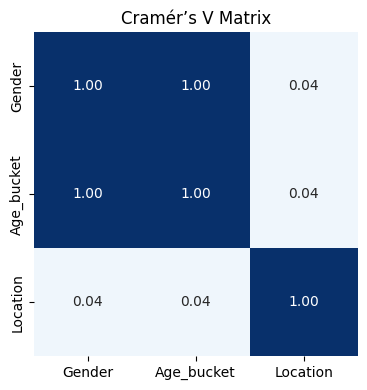

In [281]:
plot_cramer_matrix(cramer_matrix)

The tables below makes this explicit: **every female candidate is aged 55 – 74, while every male candidate is aged 25 – 34.**

In [282]:
female_candidates = reversed_skills_matching_filtered.filter(
    pl.col("Gender") == "Female"
)
display(female_candidates["Age_bucket"].value_counts())

Age_bucket,count
str,u32
"""55-74""",3420


In [283]:
male_candidates = reversed_skills_matching_filtered.filter(pl.col("Gender") == "Male")
display(male_candidates["Age_bucket"].value_counts())

Age_bucket,count
str,u32
"""25-34""",3984


## Exporting the Cleaned Data

- **Export the cleaned CVs**, the **cleaned parsed skills**, the **cleaned matcher result** to a **new** CSV file, ensuring the schema and data types are preserved.

In [284]:
raw_cv_cleaned.write_csv(
    "../data/Adecco_Dataset_cleaned/CV_translated_cleaned.csv", separator=";"
)
raw_skills_cleaned.write_csv(
    "../data/Adecco_Dataset_cleaned/Skills_cleaned.csv", separator=";"
)
reversed_skills_matching.write_csv(
    "../data/Adecco_Dataset_cleaned/reversed_skills_matching_candidate.csv",
    separator=";",
)